In [87]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

In [88]:
# train = pd.read_csv('../data/stock50.csv')
# train = pd.read_csv('stock50.csv')
train = pd.read_csv('Google_Stock_Price_v2.csv')
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [89]:
df = train
df.drop(df.columns[[0,3,5]], axis=1, inplace=True) 
df.tail(5)

,Open,High,Close
1144,790.90,792.74,789.91
1145,790.68,797.86,791.55
1146,793.70,794.23,785.05
1147,783.33,785.93,782.79
1148,782.75,782.78,771.82


In [90]:
#print( type(df['High']) )
#print( df['High'])
#print( df['High'].mean() )

In [91]:
# normalization
#df['High'] = df['High'] / 1000
#df['Open'] = df['Open'] / 1000
#df['Close'] = df['Close'].astype(float) / 1000
#df.tail(5)

In [92]:
# normalization

# one easy way by using Pandas: (here I want to use mean normalization)
# normalized_df=(df-df.mean())/df.std()

#to use min-max normalization:
#normalized_df=(df-df.min())/(df.max()-df.min())

# df['High'] = ( df['High'] - df['High'].mean() ) / ( df['High'].std() )
# print(df['High'])

df['High'] = ( df['High'] - df['High'].min() ) / ( df['High'].max() - df['High'].min() )
df['Open'] = ( df['Open'] - df['Open'].min() ) / ( df['Open'].max() - df['Open'].min() )
df['Close'] = ( df['Close'] - df['Close'].min() ) / ( df['Close'].max() - df['Close'].min() )

print( df.head(5) )
print( df.tail(5) )

       Open      High     Close
0  0.085814  0.096401  0.400014
1  0.097012  0.098344  0.406650
2  0.094334  0.092517  0.385210
3  0.091562  0.088819  0.364396
4  0.079842  0.076718  0.300631
          Open      High     Close
1144  0.952043  0.955292  0.693127
1145  0.951633  0.964853  0.696932
1146  0.957251  0.958074  0.681850
1147  0.937960  0.942574  0.676606
1148  0.936881  0.936691  0.651151


In [93]:
import datetime

stock_name = 'Google'
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today

df.to_csv(file_name)

In [94]:
#######################################################

In [95]:
def load_data(stock, seq_len):
    
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    
    # seq_len (use how many days features to train)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    
    # 0.8 for training, 0.2 for testing
    row = round(0.8 * result.shape[0]) 
    
    # training
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    # testing
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    # reshape (the features)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features) )
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features) )  

    return [x_train, y_train, x_test, y_test]

In [96]:
# note: window size means that using 'window' days to train
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (914, 5, 3)
y_train (914,)
X_test (229, 5, 3)
y_test (229,)


C:\Users\user\Anaconda3\envs\myTensorFlow-Gpu-V2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [97]:
print("X_train", X_train[0])
print("y_train", y_train[0])

X_train [[0.93688146 0.93669113 0.65115092]
 [0.93796041 0.94257381 0.67660572]
 [0.95725128 0.95807422 0.68184982]
 [0.95163331 0.96485331 0.69693243]
 [0.95204256 0.95529161 0.69312697]]
y_train 0.6962595136439577


In [98]:
#######################################################

In [99]:
'''
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model
'''

'\ndef build_model(layers):\n    model = Sequential()\n\n    model.add(LSTM(\n        input_dim=layers[0],\n        output_dim=layers[1],\n        return_sequences=True))\n    model.add(Dropout(0.2))\n\n    model.add(LSTM(\n        layers[2],\n        return_sequences=False))\n    model.add(Dropout(0.2))\n\n    model.add(Dense(\n        output_dim=layers[2]))\n    model.add(Activation("linear"))\n\n    start = time.time()\n    model.compile(loss="mse", optimizer="rmsprop",metrics=[\'accuracy\'])\n    print("Compilation Time : ", time.time() - start)\n    return model\n\ndef build_model2(layers):\n        d = 0.2\n        model = Sequential()\n        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))\n        model.add(Dropout(d))\n        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))\n        model.add(Dropout(d))\n        model.add(Dense(16,init=\'uniform\',activation=\'relu\'))        \n        model.add(Dense(1,init=\'u

In [100]:
import time

def build_model_3(layers):
        d = 0.1 # dropout
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), recurrent_dropout=0.2, return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), recurrent_dropout=0.2, return_sequences=True))
        model.add(Dropout(d))
        model.add(Flatten())
        model.add(Dropout(d))
        model.add(Dense(32, activation='relu'))   
        model.add(Dropout(d))
        # model.add(Dense(1, activation='linear'))
        model.add(Dense(1, activation='sigmoid'))
        start = time.time()
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        print("Compilation Time : ", time.time() - start)
        return model

In [101]:
# model = build_model2([3,window,1])
model = build_model_3([3,window,1])
model.summary()

Compilation Time :  0.02393484115600586
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 128)            67584     
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 

In [102]:
#######################################################

In [103]:
from keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint('model.h1', monitor='val_loss', save_best_only=True)] # record best model every epoch

In [104]:
train_data = X_train
train_label = y_train

train_history = model.fit(train_data, 
                          train_label,
                          batch_size = 256,
                          epochs = 300,
                          validation_split = 0.2,
                          shuffle =  True,
                          callbacks = callbacks,
                          verbose=1)

Train on 731 samples, validate on 183 samples
Epoch 1/300
731/731 [==============================] - 2s 3ms/step - loss: 0.0784 - acc: 0.0014 - val_loss: 0.0941 - val_acc: 0.0000e+00
Epoch 2/300
731/731 [==============================] - 0s 125us/step - loss: 0.0734 - acc: 0.0014 - val_loss: 0.0948 - val_acc: 0.0000e+00
Epoch 3/300
731/731 [==============================] - 0s 120us/step - loss: 0.0682 - acc: 0.0014 - val_loss: 0.0903 - val_acc: 0.0055
Epoch 4/300
731/731 [==============================] - 0s 115us/step - loss: 0.0627 - acc: 0.0014 - val_loss: 0.0787 - val_acc: 0.0055
Epoch 5/300
731/731 [==============================] - 0s 130us/step - loss: 0.0561 - acc: 0.0014 - val_loss: 0.0617 - val_acc: 0.0055
Epoch 6/300
731/731 [==============================] - 0s 117us/step - loss: 0.0464 - acc: 0.0014 - val_loss: 0.0457 - val_acc: 0.0055
Epoch 7/300
731/731 [==============================] - 0s 116us/step - loss: 0.0356 - acc: 0.0014 - val_loss: 0.0307 - val_acc: 0.0055
Epo

Epoch 61/300
731/731 [==============================] - 0s 111us/step - loss: 0.0048 - acc: 0.0014 - val_loss: 0.0185 - val_acc: 0.0055
Epoch 62/300
731/731 [==============================] - 0s 108us/step - loss: 0.0048 - acc: 0.0014 - val_loss: 0.0184 - val_acc: 0.0055
Epoch 63/300
731/731 [==============================] - 0s 108us/step - loss: 0.0043 - acc: 0.0014 - val_loss: 0.0179 - val_acc: 0.0055
Epoch 64/300
731/731 [==============================] - 0s 108us/step - loss: 0.0044 - acc: 0.0014 - val_loss: 0.0177 - val_acc: 0.0055
Epoch 65/300
731/731 [==============================] - 0s 106us/step - loss: 0.0046 - acc: 0.0014 - val_loss: 0.0178 - val_acc: 0.0055
Epoch 66/300
731/731 [==============================] - 0s 112us/step - loss: 0.0048 - acc: 0.0014 - val_loss: 0.0178 - val_acc: 0.0055
Epoch 67/300
731/731 [==============================] - 0s 109us/step - loss: 0.0044 - acc: 0.0014 - val_loss: 0.0183 - val_acc: 0.0055
Epoch 68/300
731/731 [==========================

731/731 [==============================] - 0s 108us/step - loss: 0.0038 - acc: 0.0014 - val_loss: 0.0211 - val_acc: 0.0055
Epoch 122/300
731/731 [==============================] - 0s 109us/step - loss: 0.0038 - acc: 0.0014 - val_loss: 0.0227 - val_acc: 0.0055
Epoch 123/300
731/731 [==============================] - 0s 112us/step - loss: 0.0037 - acc: 0.0014 - val_loss: 0.0217 - val_acc: 0.0055
Epoch 124/300
731/731 [==============================] - 0s 108us/step - loss: 0.0036 - acc: 0.0014 - val_loss: 0.0213 - val_acc: 0.0055
Epoch 125/300
731/731 [==============================] - 0s 109us/step - loss: 0.0037 - acc: 0.0014 - val_loss: 0.0208 - val_acc: 0.0055
Epoch 126/300
731/731 [==============================] - 0s 111us/step - loss: 0.0035 - acc: 0.0014 - val_loss: 0.0203 - val_acc: 0.0055
Epoch 127/300
731/731 [==============================] - 0s 108us/step - loss: 0.0036 - acc: 0.0014 - val_loss: 0.0224 - val_acc: 0.0055
Epoch 128/300
731/731 [==============================] 

Epoch 181/300
731/731 [==============================] - 0s 112us/step - loss: 0.0028 - acc: 0.0014 - val_loss: 0.0203 - val_acc: 0.0055
Epoch 182/300
731/731 [==============================] - 0s 106us/step - loss: 0.0029 - acc: 0.0014 - val_loss: 0.0209 - val_acc: 0.0055
Epoch 183/300
731/731 [==============================] - 0s 105us/step - loss: 0.0028 - acc: 0.0014 - val_loss: 0.0220 - val_acc: 0.0055
Epoch 184/300
731/731 [==============================] - 0s 106us/step - loss: 0.0028 - acc: 0.0014 - val_loss: 0.0222 - val_acc: 0.0055
Epoch 185/300
731/731 [==============================] - 0s 106us/step - loss: 0.0029 - acc: 0.0014 - val_loss: 0.0204 - val_acc: 0.0055
Epoch 186/300
731/731 [==============================] - 0s 111us/step - loss: 0.0029 - acc: 0.0014 - val_loss: 0.0197 - val_acc: 0.0055
Epoch 187/300
731/731 [==============================] - 0s 117us/step - loss: 0.0031 - acc: 0.0014 - val_loss: 0.0214 - val_acc: 0.0055
Epoch 188/300
731/731 [==================

Epoch 241/300
731/731 [==============================] - 0s 112us/step - loss: 0.0023 - acc: 0.0014 - val_loss: 0.0184 - val_acc: 0.0055
Epoch 242/300
731/731 [==============================] - 0s 109us/step - loss: 0.0022 - acc: 0.0014 - val_loss: 0.0187 - val_acc: 0.0055
Epoch 243/300
731/731 [==============================] - 0s 106us/step - loss: 0.0024 - acc: 0.0014 - val_loss: 0.0184 - val_acc: 0.0055
Epoch 244/300
731/731 [==============================] - 0s 108us/step - loss: 0.0024 - acc: 0.0014 - val_loss: 0.0186 - val_acc: 0.0055
Epoch 245/300
731/731 [==============================] - 0s 106us/step - loss: 0.0021 - acc: 0.0014 - val_loss: 0.0198 - val_acc: 0.0055
Epoch 246/300
731/731 [==============================] - 0s 105us/step - loss: 0.0023 - acc: 0.0014 - val_loss: 0.0190 - val_acc: 0.0055
Epoch 247/300
731/731 [==============================] - 0s 108us/step - loss: 0.0023 - acc: 0.0014 - val_loss: 0.0182 - val_acc: 0.0055
Epoch 248/300
731/731 [==================

In [105]:
import matplotlib.pyplot as pyplot

def my_show_train_history(input_train_history, input_train, input_validation):
    pyplot.plot(input_train_history.history[input_train] )
    pyplot.plot(input_train_history.history[input_validation])
    pyplot.title('Train History')
    pyplot.ylabel(input_train)
    # pyplot.ylabel('Accuracy')
    pyplot.xlabel('Epoch')
    pyplot.legend(['my_train','my_validation'], loc='upper left')
    pyplot.show()

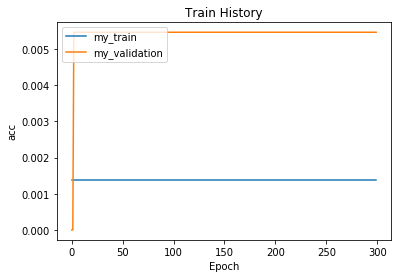

In [106]:
my_show_train_history( train_history, 'acc', 'val_acc' )


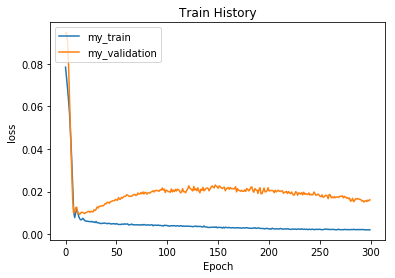

In [107]:
my_show_train_history( train_history, 'loss', 'val_loss' )


In [108]:
import math

# Mean Squared Error
# Root Mean Squared Error

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score (loss): %.2f MSE (%.2f RMSE)' % ( trainScore[0], math.sqrt(trainScore[0]) ) )

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score (loss): %.2f MSE (%.2f RMSE)' % ( testScore[0], math.sqrt(testScore[0]) ) )

Train Score (loss): 0.00 MSE (0.07 RMSE)
Test Score (loss): 0.03 MSE (0.17 RMSE)


In [109]:
# print(X_test[-1])
ratio=[]
diff=[]

predicted_result = model.predict(X_test)

for index in range(len(y_test)):
    predicted_result_each = predicted_result[index][0]
    ratio.append( (y_test[index]/predicted_result_each)-1 )
    diff.append( abs(y_test[index]- predicted_result_each) )
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

In [110]:
print(y_test)

[0.4762855  0.46129571 0.44226842 0.41226564 0.39015222 0.40593094
 0.40108131 0.41057175 0.40648784 0.35782903 0.35801466 0.37024318
 0.38530258 0.40115092 0.39449137 0.36963987 0.4039586  0.43774364
 0.44062094 0.45210692 0.45134119 0.43447188 0.42254502 0.42857806
 0.42753388 0.4345879  0.43068962 0.43790607 0.46848895 0.60845554
 0.58348803 0.57487934 0.58360405 0.59917394 0.58316317 0.58207258
 0.61390848 0.636602   0.63753017 0.62467514 0.61193614 0.62300446
 0.60615834 0.61079915 0.60376833 0.59381381 0.5943243  0.55870614
 0.5451318  0.54369315 0.52234546 0.50315575 0.50245963 0.49403657
 0.45895211 0.46196863 0.48183126 0.49429181 0.47867552 0.43544645
 0.43618897 0.44554019 0.43765083 0.45231576 0.42741786 0.40883145
 0.43059681 0.42637368 0.42725543 0.40950436 0.42344997 0.42716261
 0.41727771 0.40493317 0.40753202 0.38750696 0.34583256 0.3466447
 0.34636625 0.34246798 0.34773529 0.34427789 0.31518006 0.32427603
 0.32494895 0.32339428 0.32954335 0.27956191 0.26714776 0.26617

In [111]:
print(predicted_result)

[[0.6645168 ]
 [0.6726728 ]
 [0.67279875]
 [0.66680336]
 [0.6515289 ]
 [0.6310419 ]
 [0.6137746 ]
 [0.6047897 ]
 [0.6025981 ]
 [0.60287607]
 [0.5844736 ]
 [0.5588525 ]
 [0.5487367 ]
 [0.5531933 ]
 [0.56718266]
 [0.57721615]
 [0.5698262 ]
 [0.57590896]
 [0.6025998 ]
 [0.6225249 ]
 [0.6352019 ]
 [0.64814085]
 [0.65039426]
 [0.6427871 ]
 [0.6383179 ]
 [0.6350464 ]
 [0.6344002 ]
 [0.63429546]
 [0.63612515]
 [0.64323086]
 [0.69628894]
 [0.7340684 ]
 [0.7491474 ]
 [0.7572939 ]
 [0.77226156]
 [0.77099186]
 [0.76883775]
 [0.7738933 ]
 [0.78434914]
 [0.7914197 ]
 [0.79380614]
 [0.79325837]
 [0.7930516 ]
 [0.79030573]
 [0.7874514 ]
 [0.78467005]
 [0.78175634]
 [0.77825004]
 [0.77116835]
 [0.76041627]
 [0.75167733]
 [0.7430196 ]
 [0.72901565]
 [0.71894777]
 [0.7116455 ]
 [0.6965555 ]
 [0.68307036]
 [0.68096167]
 [0.6860457 ]
 [0.685964  ]
 [0.6746576 ]
 [0.6625531 ]
 [0.65680736]
 [0.6507523 ]
 [0.6491575 ]
 [0.6465277 ]
 [0.63630235]
 [0.63191944]
 [0.63287073]
 [0.6307842 ]
 [0.62387586]
 [0.62

In [112]:
print(ratio)

[-0.28326041207308583, -0.3142346378564813, -0.3426438111647718, -0.3817283111597356, -0.40117434336900504, -0.35672899867987473, -0.34653322508154516, -0.3211330082888353, -0.32544118443981185, -0.40646336395207106, -0.3874579470226893, -0.33749391448864874, -0.29783703865283173, -0.27484490540257056, -0.3044720936340364, -0.3596161943669227, -0.29108451983789607, -0.23990826097163997, -0.26880005674306207, -0.2737528866090516, -0.2894523582453512, -0.32966441122558465, -0.35032480882465344, -0.33325037320727746, -0.3302179224011156, -0.31565964092774623, -0.3211073535489789, -0.3096181585317087, -0.2635270640557943, -0.05406350465307541, -0.1620030271148445, -0.216858614159255, -0.22097569187533384, -0.20879601289319083, -0.24486313856713504, -0.2450340775738029, -0.20151100356423057, -0.17740338684195278, -0.18718574439495583, -0.21069041395640142, -0.22911134711634895, -0.21462605433384496, -0.23566342491062142, -0.22713562604722182, -0.23326272382575464, -0.2432312061498103, -0.23

In [113]:
print(diff)

[0.18823130446770903, 0.2113770962713024, 0.23053032880106467, 0.25453772048284545, 0.2613766765979527, 0.22511093955502914, 0.21269329079498234, 0.19421792748422728, 0.1961102299993857, 0.24504703430468244, 0.22645894499021574, 0.1886093157418079, 0.1634341111890411, 0.15204235228134333, 0.172691291994435, 0.2075762746062773, 0.16586758165649834, 0.13816531681054056, 0.16197886033471526, 0.1704179930492215, 0.18386067963717517, 0.21366897094265197, 0.2278492451046048, 0.2142090405961103, 0.2107840051605856, 0.20045852569297173, 0.20371056575599894, 0.1963893933930866, 0.16763619245127653, 0.0347753143474302, 0.11280091655969138, 0.15918905455747012, 0.16554336838184924, 0.1581199427294515, 0.18909838936734735, 0.1889192796780268, 0.15492926657210926, 0.1372912918921635, 0.14681897829254753, 0.1667445410220726, 0.1818699930890142, 0.17025391379911003, 0.1868932562943667, 0.17950658758828042, 0.18368305528409545, 0.19085624388602163, 0.18743204221845833, 0.21954389420205367, 0.226036552

In [115]:
# normalization (reverse)

df_2 = pd.read_csv('Google_Stock_Price_v2.csv')

normalization_min = df_2['Close'].min()
normalization_max = df_2['Close'].max()

# y = (x - min) / (max - min)
# x = y * (max - min) + min

y_test = ( y_test * (normalization_max-normalization_min) ) + normalization_min
predicted_result = ( predicted_result * (normalization_max-normalization_min) ) + normalization_min


In [116]:
print(y_test)

[696.46 690.   681.8  668.87 659.34 666.14 664.05 668.14 666.38 645.41
 645.49 650.76 657.25 664.08 661.21 650.5  665.29 679.85 681.09 686.04
 685.71 678.44 673.3  675.9  675.45 678.49 676.81 679.92 693.1  753.42
 742.66 738.95 742.71 749.42 742.52 742.05 755.77 765.55 765.95 760.41
 754.92 759.69 752.43 754.43 751.4  747.11 747.33 731.98 726.13 725.51
 716.31 708.04 707.74 704.11 688.99 690.29 698.85 704.22 697.49 678.86
 679.18 683.21 679.81 686.13 675.4  667.39 676.77 674.95 675.33 667.68
 673.69 675.29 671.03 665.71 666.83 658.2  640.24 640.59 640.47 638.79
 641.06 639.57 627.03 630.95 631.24 630.57 633.22 611.68 606.33 605.91
 613.82 609.15 591.44 579.17 575.15 573.35 574.94 568.92 569.63 580.11
 584.41 584.38 594.29 586.22 578.88 578.48 562.76 567.74 563.13 559.16
 569.92 563.66 575.93 579.94 569.29 562.96 557.52 559.55 563.55 566.94
 578.86 576.65 578.98 568.85 577.01 569.42 579.27 586.62 592.71 589.91
 602.01 607.79 599.16 612.43 598.76 621.34 627.21 609.44 602.35 603.57
 611.9

In [117]:
print(predicted_result)

[[777.5802 ]
 [781.0951 ]
 [781.14935]
 [778.56555]
 [771.9829 ]
 [763.1538 ]
 [755.7123 ]
 [751.8402 ]
 [750.8956 ]
 [751.0155 ]
 [743.0847 ]
 [732.0431 ]
 [727.6836 ]
 [729.6042 ]
 [735.63306]
 [739.9571 ]
 [736.7723 ]
 [739.39374]
 [750.8964 ]
 [759.48334]
 [764.9466 ]
 [770.5228 ]
 [771.4939 ]
 [768.2156 ]
 [766.2895 ]
 [764.87964]
 [764.6011 ]
 [764.55597]
 [765.3445 ]
 [768.40674]
 [791.2727 ]
 [807.5541 ]
 [814.0526 ]
 [817.56335]
 [824.01385]
 [823.4667 ]
 [822.5383 ]
 [824.71704]
 [829.22314]
 [832.27026]
 [833.2987 ]
 [833.0626 ]
 [832.9735 ]
 [831.79016]
 [830.56006]
 [829.36145]
 [828.1057 ]
 [826.5946 ]
 [823.5427 ]
 [818.909  ]
 [815.1429 ]
 [811.41174]
 [805.3766 ]
 [801.0377 ]
 [797.89075]
 [791.3876 ]
 [785.57605]
 [784.66724]
 [786.8583 ]
 [786.82306]
 [781.95044]
 [776.7339 ]
 [774.2577 ]
 [771.6482 ]
 [770.96094]
 [769.8276 ]
 [765.4209 ]
 [763.532  ]
 [763.942  ]
 [763.0428 ]
 [760.06555]
 [760.4083 ]
 [761.302  ]
 [761.09766]
 [757.46497]
 [755.7854 ]
 [750.9863 ]

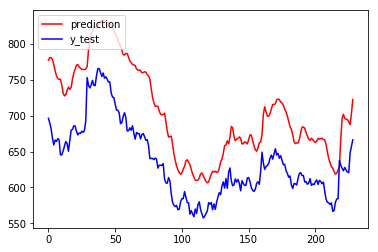

In [118]:
import matplotlib.pyplot as plt2

plt2.plot(predicted_result,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()